Nielsen data
===

In [1]:
import pandas as pd
import numpy as np

## Loading the data

In [2]:
panelist = pd.read_table("../../Nielsen/panelists_2016.tsv").set_index('Household_Cd')[['Fips_State_Cd', 'Fips_State_Desc', 'Fips_County_Cd', 'Fips_County_Desc', 'Panelist_ZipCd']]
panelist['household_county_fips'] = np.vectorize(int)(panelist.Fips_State_Cd * 1e3 + panelist.Fips_County_Cd)
panelist['household_zip3'] = panelist.Panelist_ZipCd // 100
panelist = panelist[['Fips_State_Desc', 'Fips_County_Desc', 'household_county_fips', 'household_zip3']].rename(columns={'Fips_State_Desc': 'household_state', 'Fips_County_Desc': 'household_county'})

In [3]:
panelist.head()

,household_state,household_county,household_county_fips,household_zip3
Household_Cd,,,,
2058978,CA,ALAMEDA,6001,945
2059041,CA,SONOMA,6097,954
2053746,PA,LANCASTER,42071,175
2053784,PA,LANCASTER,42071,176
2055288,CA,ALAMEDA,6001,945


In [4]:
purchases = pd.read_csv("../../Nielsen/purchases_subset_2016.csv")
purchases['upc_price'] = purchases.total_price_paid / purchases.quantity
purchases = purchases[['trip_code_uc', 'upc', 'upc_price']]


In [5]:
purchases.head()

,trip_code_uc,upc,upc_price
0,1074839376,1111040601,1.49
1,1067492860,1111040601,1.13
2,1073807635,1111040601,1.21
3,1066280722,1111040601,1.82
4,1074711109,1111040601,1.48


In [6]:
trips = pd.read_table("../../Nielsen/trips_2016.tsv", parse_dates=['purchase_date']).set_index('trip_code_uc')[['purchase_date', 'retailer_code', 'store_code_uc', 'store_zip3', 'household_code']]
# colonnes à enlever : panel_year, total_spent, method_of_payment_cd

In [7]:
trips.head()

,purchase_date,retailer_code,store_code_uc,store_zip3,household_code
trip_code_uc,,,,,
1065667000,2016-10-23,2,4239361,190.0,2054802
1065667001,2016-12-20,9850,0,NaN,8648515
1065667002,2016-11-14,6920,3727506,730.0,30230428
1065667003,2016-08-10,6920,3001662,605.0,2071112
1065667004,2016-04-25,5851,0,NaN,2076738


In [8]:
# Proportion of unnumerotated stores
print(f"Proportion of unnumerotated stores : {len(trips[trips.store_code_uc==0])/len(trips)} (data droped, over {len(trips)} trips)")

Proportion of unnumerotated stores : 0.48677700294119425 (data droped, over 10745635 trips)


## Getting the store state

In [9]:
zip_to_state = pd.read_table('zip_prefixes.txt', header=0, names=['zip3','state', 'distib_center', 'towns'])[['zip3', 'state']]

non_null = trips[trips.store_code_uc != 0]
non_null = non_null.merge(zip_to_state, left_on='store_zip3', right_on='zip3')[['purchase_date', 'retailer_code', 'store_code_uc', 'state', 'store_zip3', 'household_code']].rename(columns={'state': 'store_state'})
non_null

,purchase_date,retailer_code,store_code_uc,store_state,store_zip3,household_code
0,2016-10-23,2,4239361,PA,190.0,2054802
1,2016-03-20,24,254521,PA,190.0,30367513
2,2016-02-24,120,1021442,PA,190.0,30730891
3,2016-06-14,120,4301315,PA,190.0,30201210
4,2016-11-16,2,977112,PA,190.0,8646012
...,...,...,...,...,...,...
5514902,2016-12-24,45,1996462,VT,53.0,8286051
5514903,2016-01-09,4901,3520966,VT,53.0,8306752
5514904,2016-01-19,34,1997671,VT,53.0,8620167
5514905,2016-12-28,45,1996462,VT,53.0,8286051


## Getting the store county - mode

In [10]:
##
non_null_merged = non_null.merge(panelist, left_on='household_code', right_on='Household_Cd')[['retailer_code', 'store_code_uc', 'store_state', 'store_zip3', 'household_state', 'household_county_fips', 'household_county', 'household_zip3']]
non_null_merged

,retailer_code,store_code_uc,store_state,store_zip3,household_state,household_county_fips,household_county,household_zip3
0,2,4239361,PA,190.0,PA,42045,DELAWARE,190
1,6905,2890557,PA,190.0,PA,42045,DELAWARE,190
2,6905,2890557,PA,190.0,PA,42045,DELAWARE,190
3,2,4239361,PA,190.0,PA,42045,DELAWARE,190
4,6920,7620551,PA,190.0,PA,42045,DELAWARE,190
...,...,...,...,...,...,...,...,...
5514902,6920,7847066,WY,823.0,WY,56007,CARBON,823
5514903,272,2723868,WY,823.0,WY,56007,CARBON,823
5514904,6920,7847066,WY,823.0,WY,56007,CARBON,823
5514905,6920,7847066,WY,823.0,WY,56007,CARBON,823


In [11]:
# The store county is assumed to be the one where the maximum of households comes form.

# Fisrt, we delete all the housolds that do not come from the store state.

before_deletion = len(non_null_merged)
non_null_state = non_null_merged[non_null_merged.household_state == non_null_merged.store_state] # TOUT RENOMMER
suppression_rate_state = 1-len(non_null_state)/before_deletion
print(f"Taux de suppression : {suppression_rate_state} (proportion de foyers qui ne vont pas dans un store de leur Etat)")

Taux de suppression : 0.027529022701561434 (proportion de foyers qui ne vont pas dans un store de leur Etat)


In [12]:
# Fisrt, we delete all the housolds that do not come from the store zip3 zone.

non_null_zip3 = non_null_state[non_null_state.household_zip3 == non_null_state.store_zip3]
suppression_rate_zip3 = 1-len(non_null_zip3)/len(non_null_state)
print(f"Taux de suppression : {suppression_rate_zip3}")

Taux de suppression : 0.14616842874262526


In [13]:
suppression_rate = 1 - (1 - suppression_rate_state) * (1 - suppression_rate_zip3)
print(f"Taux de suppression : {suppression_rate} (proportion de foyers qui ne vont pas dans un store de leur zip3 zone)")

Taux de suppression : 0.16967357745107936 (proportion de foyers qui ne vont pas dans un store de leur zip3 zone)


In [14]:
df = non_null_zip3

In [15]:
from random import choice

def my_mode(self):
    return choice(list(pd.Series.mode(self)))

In [16]:
# Then, we select the mode :
store_loc = df.groupby(['store_code_uc'])[['retailer_code', 'store_state', 'household_county_fips', 'household_county']].agg(my_mode).rename(columns={'household_county_fips': 'guessed_store_county_fips', 'household_county': 'guessed_store_county'})
store_loc.head()


,retailer_code,store_state,guessed_store_county_fips,guessed_store_county
store_code_uc,,,,
236,363,MN,27123,RAMSEY
540,4914,NC,37183,WAKE
557,3997,IL,17031,COOK
588,848,CA,6037,LOS ANGELES
920,290,FL,12099,PALM BEACH


In [17]:
def my_max(x):
    try:
        return max(x)
    except:
        return x
def my_min(x):
    try:
        return min(x)
    except:
        return x
def my_sum(x):
    try:
        return sum(x)
    except:
        return x
def my_len(x):
    try:
        return len(x)
    except:
        return 1


In [18]:
stat = df.groupby(['store_code_uc'])[['household_county_fips', 'household_county']].agg(pd.Series.value_counts)
stat['max_obs'] = stat.household_county.apply(my_max)
stat['nb_obs'] = stat.household_county.apply(my_sum)
stat['max_freq'] = stat.max_obs / stat.nb_obs
stat['distinct_counties'] = stat.household_county.apply(my_len)
stat['criteria'] = stat.max_obs >= 4 / 3 * (stat.nb_obs - (stat.distinct_counties + 2) - stat.nb_obs)

In [19]:
stat.head()

,household_county_fips,household_county,max_obs,nb_obs,max_freq,distinct_counties,criteria
store_code_uc,,,,,,,
236,2,2,2,2,1.000000,1,True
540,8,8,8,8,1.000000,1,True
557,143,143,143,143,1.000000,1,True
588,2,2,2,2,1.000000,1,True
920,"[60, 5]","[60, 5]",60,65,0.923077,2,True


In [20]:
stat['nb_min'] = stat.household_county.apply(my_min)
stat['criteria'] = ((stat.max_obs >= 3 * (stat.nb_obs - (stat.distinct_counties - 2)*stat.nb_min - stat.max_obs)) & (stat.distinct_counties!=1)) | ((stat.distinct_counties==1) & (stat.nb_obs>=4))


In [21]:
1 - (stat.criteria.sum()/len(stat))

0.16077797826360618

In [22]:
len(stat)-stat.criteria.sum()

7663

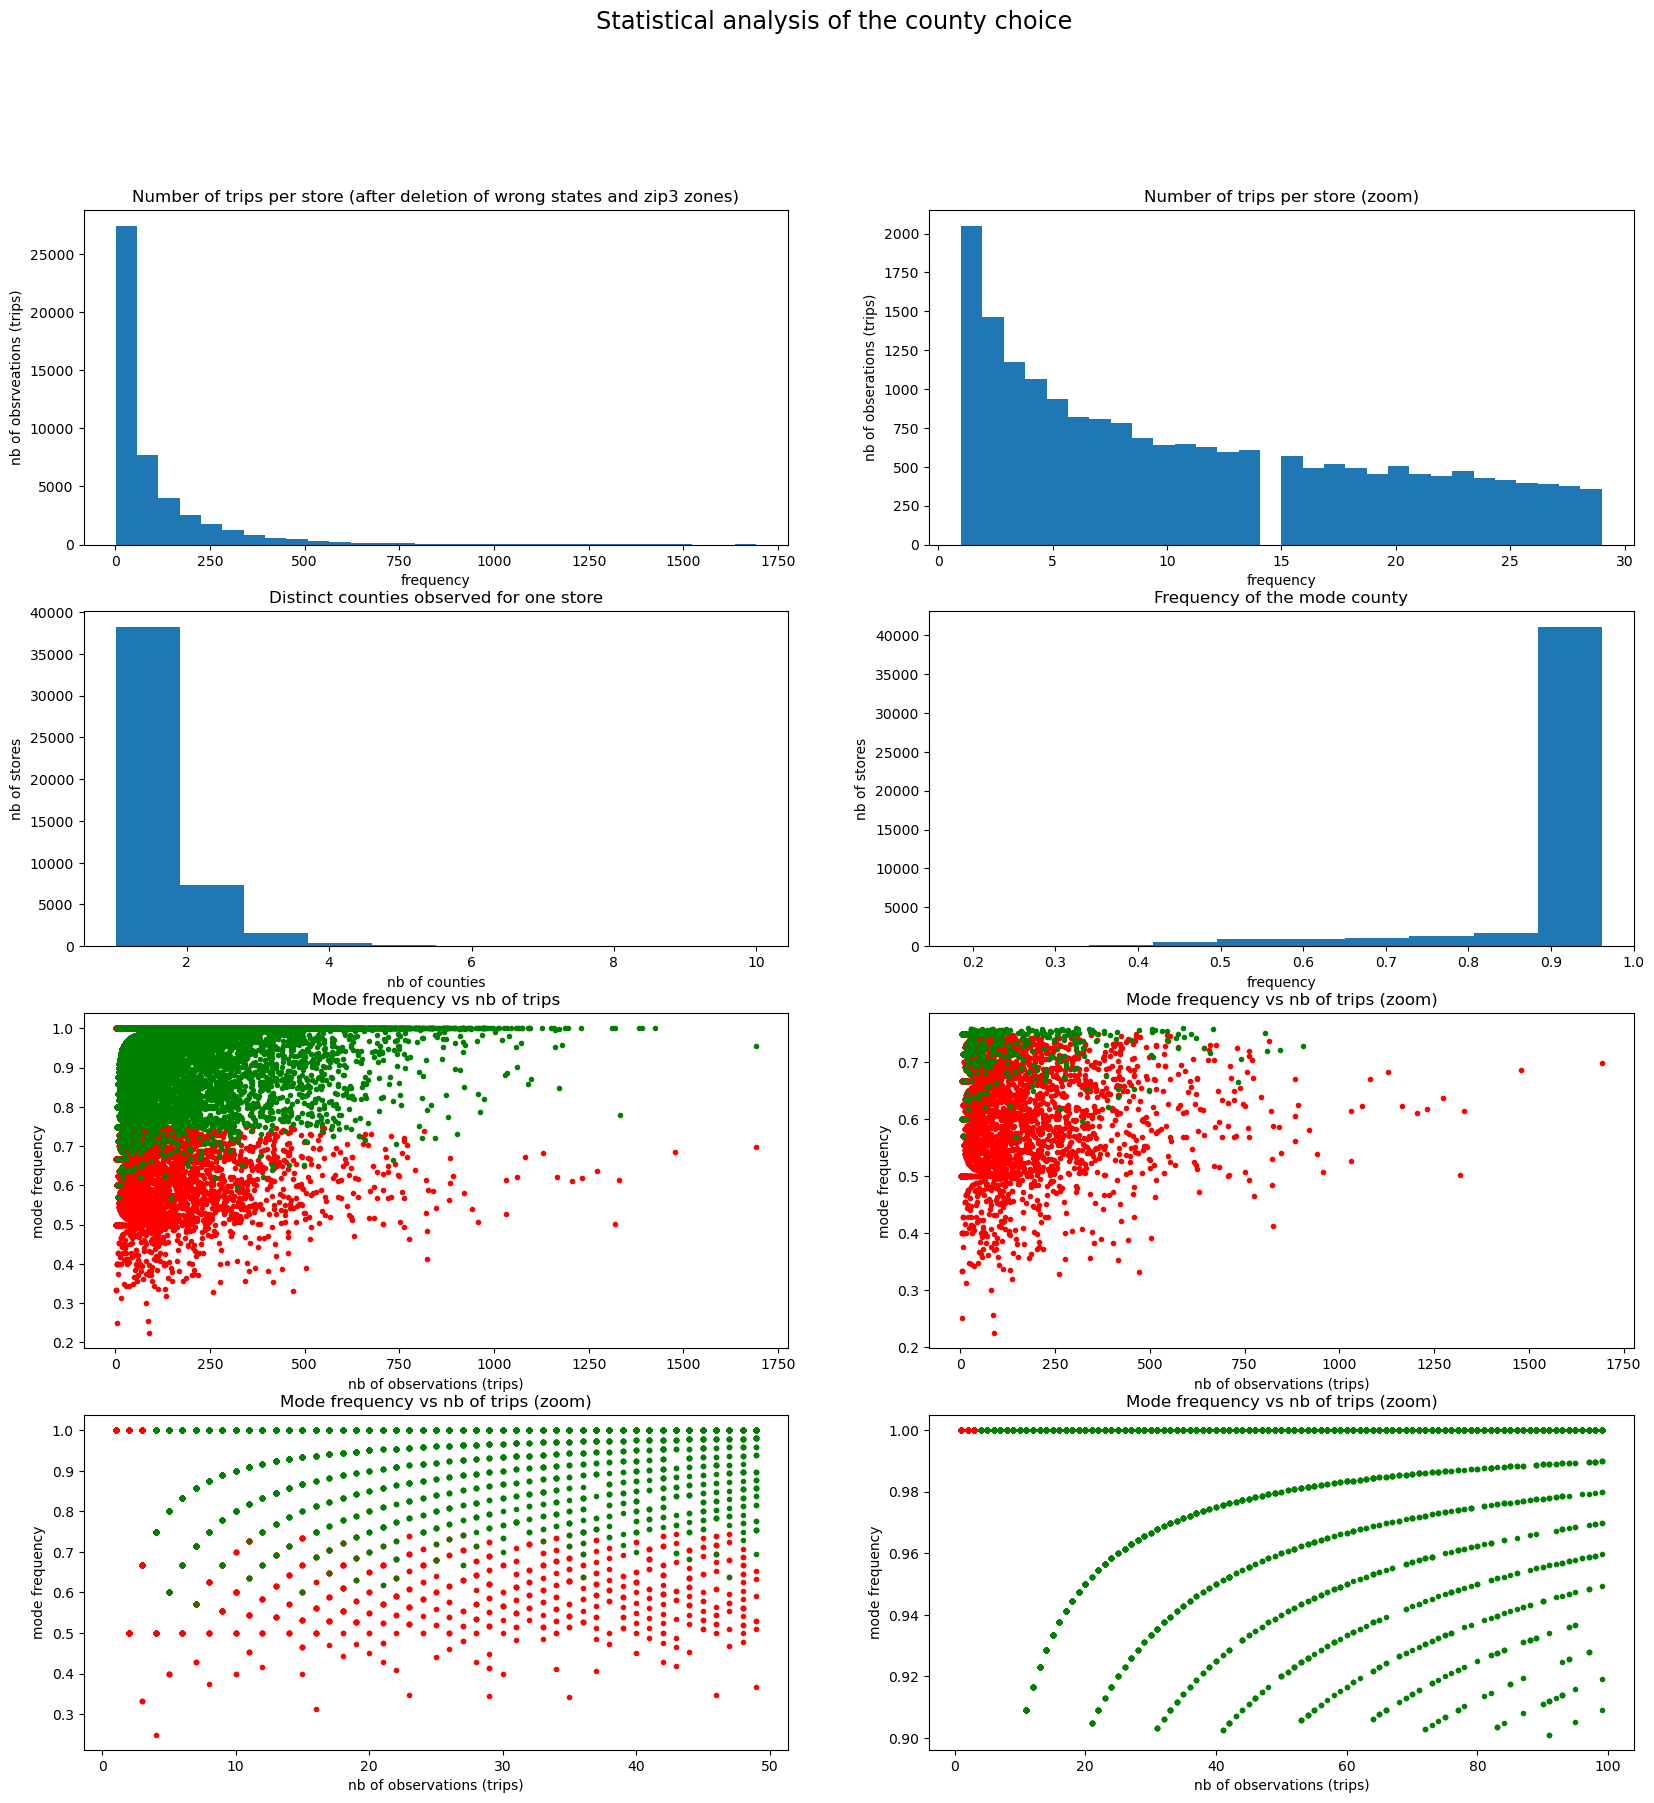

In [23]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(4,2, figsize=(20,20))
fig.suptitle("Statistical analysis of the county choice", fontsize='xx-large')

axis[0][0].hist(stat.nb_obs, bins=30);
axis[0][0].set_title(f"Number of trips per store (after deletion of wrong states and zip3 zones)")
axis[0][0].set_xlabel("frequency")
axis[0][0].set_ylabel("nb of obsrveations (trips)")

axis[0][1].hist(stat.nb_obs[stat.nb_obs<30], bins=30);
axis[0][1].set_title(f"Number of trips per store (zoom)")
axis[0][1].set_xlabel("frequency")
axis[0][1].set_ylabel("nb of obserations (trips)")

axis[1][0].hist(stat.distinct_counties.to_list())
axis[1][0].set_title(f"Distinct counties observed for one store")
axis[1][0].set_xlabel("nb of counties")
axis[1][0].set_ylabel("nb of stores")

axis[1][1].hist(stat.max_freq.to_list(), align='left')
axis[1][1].set_title(f"Frequency of the mode county")
axis[1][1].set_xlabel("frequency")
axis[1][1].set_ylabel("nb of stores")

axis[2][0].scatter(stat.nb_obs[~stat.criteria], stat.max_freq[~stat.criteria], marker='.', color='red')
axis[2][0].scatter(stat.nb_obs[stat.criteria], stat.max_freq[stat.criteria], marker='.', color='green')
axis[2][0].set_title(f"Mode frequency vs nb of trips")
axis[2][0].set_xlabel("nb of observations (trips)")
axis[2][0].set_ylabel("mode frequency")

axis[2][1].scatter(stat.nb_obs[(~stat.criteria)&(stat.max_freq<0.8)], stat.max_freq[(~stat.criteria)&(stat.max_freq<0.8)], marker='.', color='red')
axis[2][1].scatter(stat.nb_obs[(stat.criteria)&(stat.max_freq<0.76)], stat.max_freq[(stat.criteria)&(stat.max_freq<0.76)], marker='.', color='green')
axis[2][1].set_title(f"Mode frequency vs nb of trips (zoom)")
axis[2][1].set_xlabel("nb of observations (trips)")
axis[2][1].set_ylabel("mode frequency")

axis[3][0].scatter(stat.nb_obs[(~stat.criteria)&(stat.nb_obs<50)], stat.max_freq[(~stat.criteria)&(stat.nb_obs<50)], marker='.', color='red')
axis[3][0].scatter(stat.nb_obs[(stat.criteria)&(stat.nb_obs<50)], stat.max_freq[(stat.criteria)&(stat.nb_obs<50)], marker='.', color='green')
axis[3][0].set_title(f"Mode frequency vs nb of trips (zoom)")
axis[3][0].set_xlabel("nb of observations (trips)")
axis[3][0].set_ylabel("mode frequency")

axis[3][1].scatter(stat.nb_obs[(stat.criteria)&(stat.max_freq>0.9)&(stat.nb_obs<100)], stat.max_freq[(stat.criteria)&(stat.max_freq>0.9)&(stat.nb_obs<100)], marker='.', color='green')
axis[3][1].scatter(stat.nb_obs[(~stat.criteria)&(stat.max_freq>0.9)&(stat.nb_obs<100)], stat.max_freq[(~stat.criteria)&(stat.max_freq>0.9)&(stat.nb_obs<100)], marker='.', color='red')
axis[3][1].set_title(f"Mode frequency vs nb of trips (zoom)")
axis[3][1].set_xlabel("nb of observations (trips)")
axis[3][1].set_ylabel("mode frequency")

plt.show()

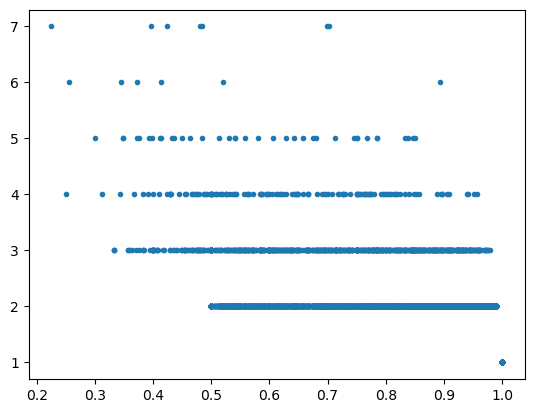

In [24]:
plt.scatter(stat.max_freq[stat.nb_obs<100], stat.distinct_counties[stat.nb_obs<100], marker ='.')

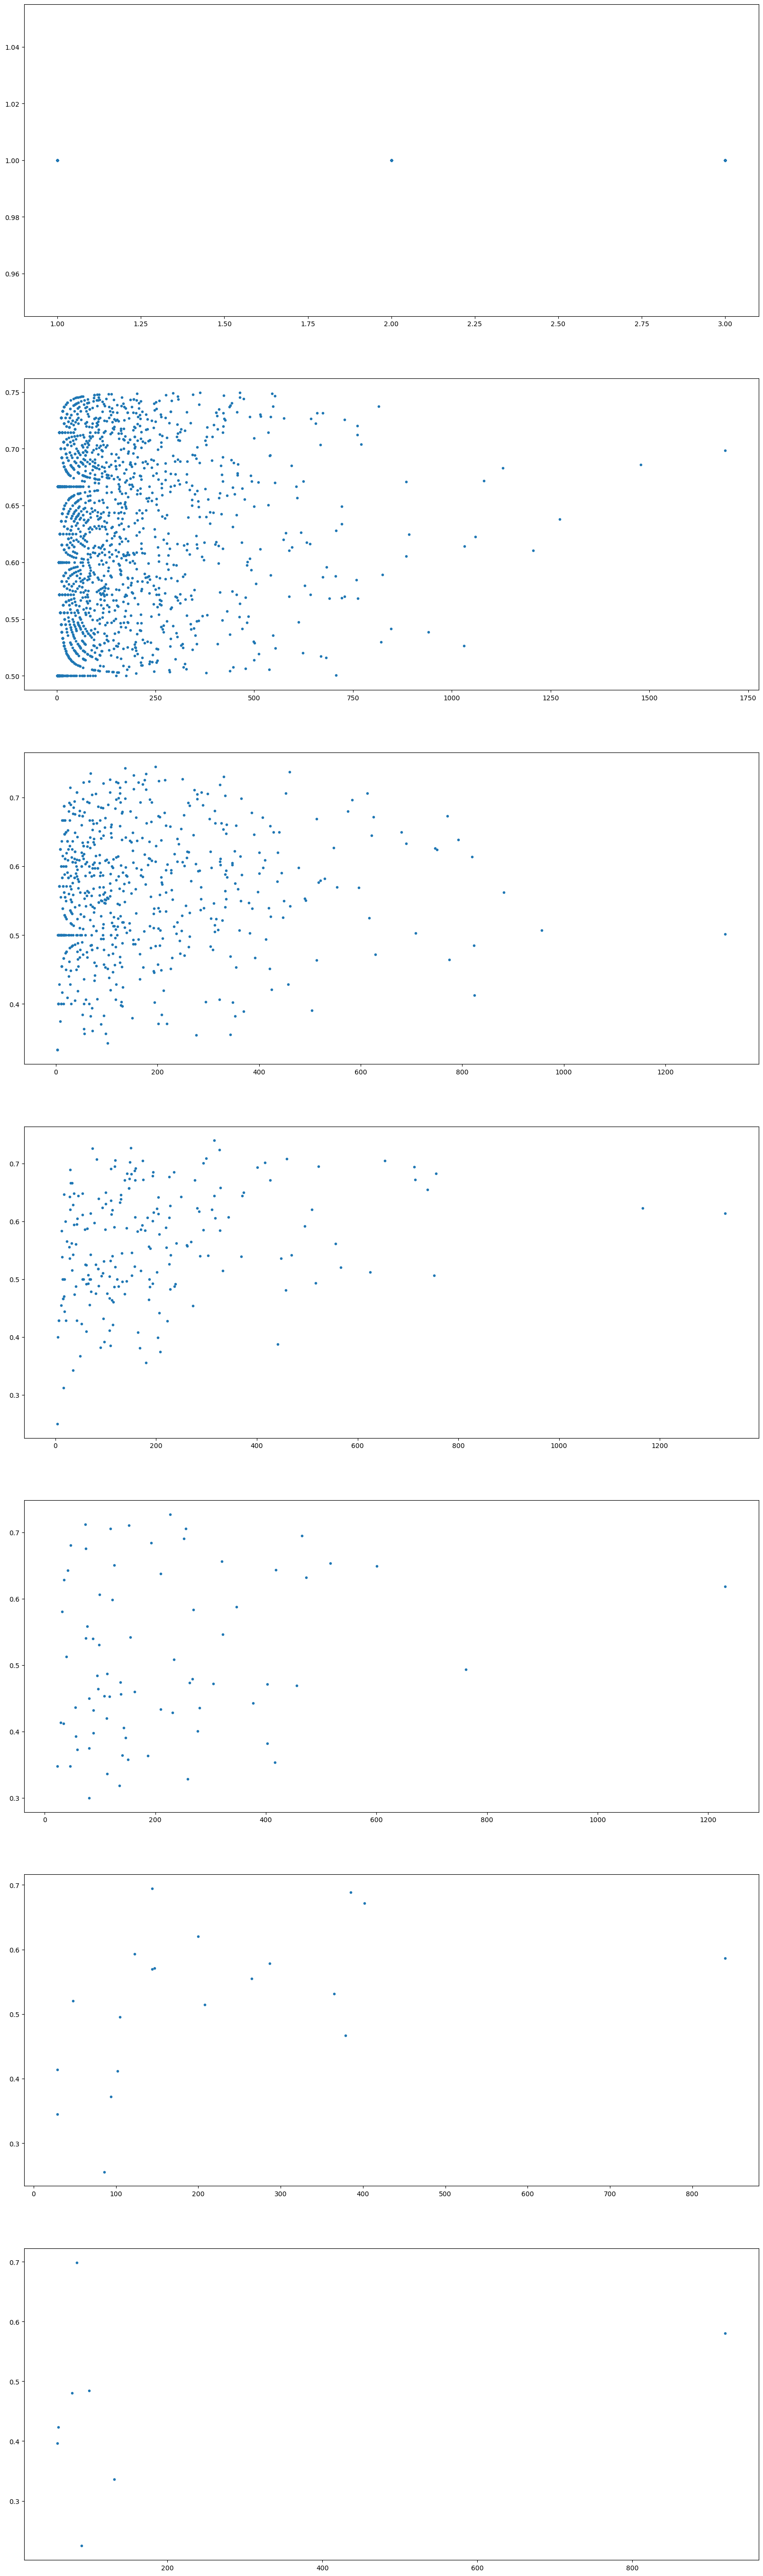

In [25]:
fig, axis = plt.subplots(7,1, figsize=(20,70))

for i in range(0,7):
    axis[i].scatter(stat.nb_obs[stat.distinct_counties==i+1][~stat.criteria], stat.max_freq[stat.distinct_counties==i+1][~stat.criteria], marker='.')


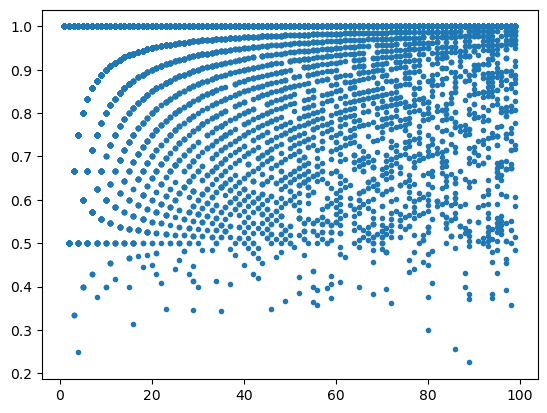

In [26]:
plt.scatter(stat.nb_obs[stat.nb_obs<100], stat.max_freq[stat.nb_obs<100], marker='.');

In [27]:
trips_loc = trips[trips.store_code_uc != 0].reset_index().merge(store_loc.reset_index(), on=['retailer_code', 'store_code_uc']).set_index('trip_code_uc')
trips_loc.head()

,purchase_date,retailer_code,store_code_uc,store_zip3,household_code,store_state,guessed_store_county_fips,guessed_store_county
trip_code_uc,,,,,,,,
1065667000,2016-10-23,2,4239361,190.0,2054802,PA,42045,DELAWARE
1065643502,2016-06-30,2,4239361,190.0,8431892,PA,42045,DELAWARE
1065702055,2016-03-08,2,4239361,190.0,30520933,PA,42045,DELAWARE
1065704006,2016-03-21,2,4239361,190.0,2054802,PA,42045,DELAWARE
1065723840,2016-01-17,2,4239361,190.0,31289665,PA,42045,DELAWARE


## Aggregating the data

In [28]:
## Merging :

prices = purchases.merge(trips_loc, on='trip_code_uc')[['trip_code_uc','purchase_date', 'retailer_code', 'store_code_uc', 'store_state', 'guessed_store_county', 'guessed_store_county_fips', 'upc', 'upc_price']]
prices['purchase_month'] = prices.purchase_date.dt.month

In [29]:
prices.head()

,trip_code_uc,purchase_date,retailer_code,store_code_uc,store_state,guessed_store_county,guessed_store_county_fips,upc,upc_price,purchase_month
0,1074839376,2016-12-22,130,4725583,OH,FRANKLIN,39049,1111040601,1.49,12
1,1074839376,2016-12-22,130,4725583,OH,FRANKLIN,39049,1111091620,1.41,12
2,1067492860,2016-01-16,130,2797839,OH,FRANKLIN,39049,1111040601,1.13,1
3,1067492860,2016-01-16,130,2797839,OH,FRANKLIN,39049,1111086901,4.57,1
4,1067492860,2016-01-16,130,2797839,OH,FRANKLIN,39049,1111078495,1.50,1


In [31]:
df_test = prices.groupby(['retailer_code'])['store_code_uc'].nunique().rename("nb_of_stores_per_retailer").to_frame()

In [32]:
df_test.sort_values("nb_of_stores_per_retailer", ascending=False)

,nb_of_stores_per_retailer
retailer_code,
6920,3289
3997,2352
4914,1761
4904,1662
6901,1332
...,...
967,1
973,1
384,1


In [33]:
new_prices = prices.merge(df_test, how = "outer", on = ['store_code_uc'])

KeyError: 'store_code_uc'

In [ ]:
new_prices.head()

In [ ]:
new_prices = prices.groupby("trip_code_uc").

In [ ]:
pd.set_option("display.max_rows", None)
new_prices[new_prices.trip_code_uc>=10000]

In [ ]:
n_prices = prices.groupby("trip_code_uc")["store_code_uc"].any().rename("store_code_uc").to_frame()

In [ ]:
new_prices.merge(prices, how = "outer", on = ['Town','State'])

In [57]:
prices_b_SA = prices[(prices.store_state == "FL")
                     &(prices.guessed_store_county == "MARION")&(prices.retailer_code == 6920)].sort_values("purchase_month")
prices_b_SA["purchase_before_opening"] = prices_b_SA.purchase_date < '2016-08-01'
prices_b_SA = prices_b_SA.groupby("store_code_uc")["purchase_before_opening"].any()
#.rename("store_code_uc").to_frame()
pd.set_option("display.max_rows", None)
prices_b_SA

store_code_uc
330962     True
633920     True
1310326    True
2987154    True
3292384    True
4925897    True
Name: purchase_before_opening, dtype: bool

In [150]:
prices_a_SA = prices[(prices.store_state == "TX")
                     &(prices.guessed_store_county == "BEXAR")
                     &(prices.purchase_date >= '2016-03-16')
                     &(prices.purchase_date <= '2016-04-16')][["trip_code_uc","retailer_code","store_code_uc"]]
prices_a_SA.describe()

,trip_code_uc,retailer_code,store_code_uc
count,1.100000e+02,110.000000,1.100000e+02
mean,1.070776e+09,3360.954545,3.213310e+06
std,3.115714e+06,3225.734015,2.582834e+06
min,1.065571e+09,42.000000,7.475000e+04
25%,1.068352e+09,42.000000,7.894680e+05
50%,1.070960e+09,927.000000,2.546838e+06
75%,1.073396e+09,6920.000000,5.576425e+06
max,1.076147e+09,6921.000000,8.136869e+06


In [151]:
prices_b_SA.iloc[0,0]

1075041672

In [152]:
prices_b_SA.iloc[0]

trip_code_uc     1075041672
retailer_code          6901
store_code_uc       3347768
Name: 65977, dtype: int64

In [153]:
# identifying stores with trips only after the 2 openings (openings March 16)
stores_b = prices_b_SA["store_code_uc"].unique().tolist()

In [154]:
print(stores_b)

[3347768, 2635055, 7822077, 263172, 1428137, 4366117, 4118507, 934548, 5747378, 6259968, 2522417, 4194439, 1806853, 6629266, 6076063, 3065354, 2826664, 6857058, 2019348, 6893058, 3616559, 7197295, 898722, 4123306, 5890344, 884173, 1328338, 7262370, 5561164, 8222170, 767706, 847500, 4452779, 5340715, 555344, 123897, 727003, 1242662, 634716, 1278806, 789468, 1468899, 74750, 3106329, 6993341, 4116895, 518022, 5753555, 8136869, 3306086, 7082958, 1279499, 353305, 876919, 4727291, 3200562, 6896934, 7771302, 7848678, 772787, 7808855, 692345, 3796107, 694763, 328065, 849918, 936422, 2740250, 6931193, 1272756, 8006433, 4882838, 7727423, 121076, 4275845, 1644050, 2978153, 5883316, 4468601, 2408410, 8064981]


In [155]:
prices_a_SA["new"]= (prices_a_SA.retailer_code == 0)
pd.set_option("display.max_rows", None)
prices_a_SA

,trip_code_uc,retailer_code,store_code_uc,new
147464,1073172801,42,555344,False
186229,1071323675,42,3796107,False
190505,1068061703,42,884173,False
234600,1071027699,6920,3306086,False
238145,1070252395,6920,2408410,False
256762,1073027613,6920,121076,False
261357,1068162279,927,2522417,False
286053,1074899410,6920,123897,False
298708,1067020179,6920,263172,False
335499,1076000419,42,1806853,False


In [156]:
potential_new_stores = prices_a_SA.copy()
for i_a in range(0, 59):
    if potential_new_stores.iloc[i_a, 2] not in stores_b:
        potential_new_stores.iloc[i_a, 3]=True

In [157]:
pd.set_option("display.max_rows", None)
potential_new_stores

,trip_code_uc,retailer_code,store_code_uc,new
147464,1073172801,42,555344,False
186229,1071323675,42,3796107,False
190505,1068061703,42,884173,False
234600,1071027699,6920,3306086,False
238145,1070252395,6920,2408410,False
256762,1073027613,6920,121076,False
261357,1068162279,927,2522417,False
286053,1074899410,6920,123897,False
298708,1067020179,6920,263172,False
335499,1076000419,42,1806853,False


In [158]:
new = potential_new_stores[potential_new_stores.new == True]
pd.set_option("display.max_rows", None)
new

,trip_code_uc,retailer_code,store_code_uc,new
363634,1068342288,4914,774802,True
363635,1068342288,4914,774802,True
420751,1065823704,6901,2546838,True
459476,1074947757,890,6793987,True
488091,1069890063,3997,7621396,True
563259,1070293624,4904,2255990,True
580943,1065570760,4914,1105692,True
590863,1068889317,6921,5576425,True
590864,1068889317,6921,5576425,True
593000,1070219374,6921,2798202,True


In [159]:
prices_b_SA = prices[(prices.store_state == "TX")
                     &(prices.guessed_store_county == "BEXAR")
                     &(prices.purchase_date >= '2016-01-01')
                     &(prices.purchase_date <= '2016-04-15')][["trip_code_uc","retailer_code","store_code_uc"]]
prices_b_SA.describe()

,trip_code_uc,retailer_code,store_code_uc
count,4.020000e+02,402.000000,4.020000e+02
mean,1.070942e+09,2906.154229,3.462581e+06
std,3.153986e+06,3194.234200,2.536816e+06
min,1.065538e+09,42.000000,7.475000e+04
25%,1.068271e+09,42.000000,8.841730e+05
50%,1.071125e+09,927.000000,3.065354e+06
75%,1.073741e+09,6920.000000,6.076063e+06
max,1.076226e+09,6921.000000,8.222170e+06


In [160]:
prices_a_SA = prices[(prices.store_state == "TX")
                     &(prices.guessed_store_county == "BEXAR")
                     &(prices.purchase_date >= '2016-04-20')
                     &(prices.purchase_date <= '2016-05-11')][["trip_code_uc","retailer_code","store_code_uc"]]
prices_a_SA.describe()

,trip_code_uc,retailer_code,store_code_uc
count,9.800000e+01,98.000000,9.800000e+01
mean,1.071128e+09,2919.785714,3.955771e+06
std,2.766546e+06,3197.542988,2.582429e+06
min,1.065589e+09,42.000000,1.238970e+05
25%,1.068934e+09,42.000000,1.703777e+06
50%,1.071521e+09,927.000000,3.827172e+06
75%,1.072715e+09,6920.000000,6.331613e+06
max,1.076056e+09,6921.000000,8.136869e+06


In [161]:
# identifying stores with trips only after the 2 openings (openings March 16)
stores_b = prices_b_SA["store_code_uc"].unique().tolist()

In [162]:
prices_a_SA["new"]= (prices_a_SA.retailer_code == 0)
pd.set_option("display.max_rows", None)
prices_a_SA

,trip_code_uc,retailer_code,store_code_uc,new
51880,1066203052,6921,4468601,False
62502,1069218970,6920,2408410,False
123547,1072820320,42,5747378,False
132562,1072308752,927,2522417,False
132563,1072308752,927,2522417,False
182909,1069300298,290,4491149,False
189760,1068211187,6920,123897,False
251892,1074108298,6920,4118507,False
251893,1074108298,6920,4118507,False
256970,1066164977,6920,2635055,False


In [163]:
potential_new_stores = prices_a_SA.copy()
for i_a in range(0, 59):
    if potential_new_stores.iloc[i_a, 2] not in stores_b:
        potential_new_stores.iloc[i_a, 3]=True

In [164]:
new = potential_new_stores[potential_new_stores.new == True]
pd.set_option("display.max_rows", None)
new

,trip_code_uc,retailer_code,store_code_uc,new
182909,1069300298,290,4491149,True
299314,1075435822,4904,3535837,True
360459,1074568790,4904,3535837,True


In [80]:
avg_prices = pd.DataFrame(prices.groupby(['retailer_code', 'store_state', 'guessed_store_county', 'guessed_store_county_fips', 'purchase_month', 'upc']).mean()['upc_price'])

C:\Users\inesn\AppData\Local\Temp\ipykernel_21732\121028078.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_prices = pd.DataFrame(prices.groupby(['retailer_code', 'store_state', 'guessed_store_county', 'guessed_store_county_fips', 'purchase_month', 'upc']).mean()['upc_price'])


In [78]:
avg_prices.head(50)

upc_price
retailer_code store_state guessed_store_county guessed_store_county_fips purchase_month upc                  
2             DE          KENT                 10001                     1              1200000341   1.315000
                                                                                        1833701212   3.823333
                                                                         2              1200000341   1.559167
                                                                                        1833701212   3.396000
                                                                                        1862761001   3.000000
                                                                         3              1200000341   1.156250
                                                                                        1833701212   3.495000
                                                                         4              1111161164   7.990000
                                                                                        1200000231   1.700000
                                                                                        1200000233   1.680000
                                                                                        1200000311   1.690000
                                                                                        1200000341   1.546667
                                                                                        1833701212   3.247500
                                                                                        2113007191   3.430000
                                                                         5              1200000341   1.381818
                                                                                        2073542091   2.270000
                                                                         6              1200000311   1.290000
                                                                                        1200000341   1.517500
                                                                                        1200000496   0.990000
                                                                                        1862751003   3.390000
                                                                                        1889422082   7.990000
                                                                                        1889422113   6.990000
                                                                                        1889430368   2.590000
                                                                                        1889434006   2.000000
                                                                                        2073509672   1.990000
                                                                         7              1822200527   1.250000
                                                                         8              1111161164   7.990000
                                                                                        1200000492   1.100000
                                                                                        1833701212   2.990000
                                                                                        1862770339   2.990000
                                                                                        1889430120   2.390000
                                                                                        1889446340   2.490000
                                                                         9              2073542091   2.020000
                                                                         10             1200000341   1.790000
                                                                                        2000012691   0.885000
                              

In [37]:
avg_prices.describe()

,upc_price
count,617795.000000
mean,2.726116
std,3.828707
min,0.000000
25%,1.320000
50%,2.000000
75%,3.000000
max,999.990000


## UPC description

In [98]:
upc = pd.read_table('../../Nielsen/products_extra_2016.tsv')

In [99]:
pd.set_option('display.max_columns', None)

In [100]:
upc.head()

,upc,upc_ver_uc,panel_year,flavor_code,flavor_descr,form_code,form_descr,formula_code,formula_descr,container_code,container_descr,salt_content_code,salt_content_descr,style_code,style_descr,type_code,type_descr,product_code,product_descr,variety_code,variety_descr,organic_claim_code,organic_claim_descr,usda_organic_seal_code,usda_organic_seal_descr,common_consumer_name_code,common_consumer_name_descr,strength_code,strength_descr,scent_code,scent_descr,dosage_code,dosage_descr,gender_code,gender_descr,target_skin_condition_code,target_skin_condition_descr,use_code,use_descr,size2_code,size2_amount,size2_units
0,3003404554,1,2016,NaN,NaN,402.0,REGULAR,NaN,NaN,NaN,NaN,NaN,NaN,582.0,SHELF-STABLE,2694.0,REGULAR,NaN,NaN,209.0,MOSTACCIOLI,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3003404593,1,2016,NaN,NaN,312.0,MEDIUM,NaN,NaN,NaN,NaN,NaN,NaN,582.0,SHELF-STABLE,2694.0,REGULAR,NaN,NaN,400.0,TWIST,4.0,NOT STATED,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3003404612,1,2016,3179.0,LIME,NaN,NaN,1301.0,RECONSTITUTED,33.0,GLASS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3003404893,1,2016,NaN,NaN,NaN,NaN,NaN,NaN,52.0,PLASTIC,NaN,NaN,NaN,NaN,47603.0,FF VITAMIN A/D,NaN,NaN,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,10020.0,MILK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3003404990,1,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,SALTED,NaN,NaN,NaN,NaN,112488.0,THIN WATER ROUND CRKR,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
upc.describe()

,upc,upc_ver_uc,panel_year,flavor_code,form_code,formula_code,container_code,salt_content_code,style_code,type_code,product_code,variety_code,organic_claim_code,usda_organic_seal_code,common_consumer_name_code,strength_code,scent_code,dosage_code,gender_code,target_skin_condition_code,use_code,size2_code,size2_amount
count,1.150343e+06,1.150343e+06,1150343.0,340149.000000,339643.000000,202599.000000,233957.000000,63378.000000,231037.000000,464120.000000,394035.000000,130594.000000,606155.000000,600103.000000,379089.000000,37294.000000,129172.000000,5176.000000,3646.000000,37276.000000,33226.000000,86675.000000,86675.000000
mean,4.205853e+10,1.050307e+00,2016.0,23120.661213,978.360093,572.153100,80.467547,17.515920,2935.024122,19859.370587,37494.415722,447.870063,260.055588,7.997384,8228.725294,601.615354,5613.793516,118.085781,9.745749,114.601594,207.394209,1729.832466,21.435805
std,8.984747e+10,2.369618e-01,0.0,30268.927839,1675.578357,1495.051561,190.151191,38.224345,5850.352650,32782.363050,48751.024346,373.398198,1570.386097,9.804756,5213.907523,597.090570,8424.259662,169.658070,11.914664,342.684383,406.250535,4218.825980,90.104633
min,2.000002e+06,1.000000e+00,2016.0,2.000000,1.000000,5.000000,1.000000,2.000000,12.000000,2.000000,4.000000,9.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,7.000000,0.000000
25%,4.133101e+09,1.000000e+00,2016.0,3575.000000,277.000000,155.000000,12.000000,7.000000,533.000000,2241.000000,3264.000000,220.000000,4.000000,2.000000,2900.000000,74.000000,263.000000,4.000000,8.000000,8.000000,55.000000,99.000000,1.000000
50%,7.702816e+09,1.000000e+00,2016.0,5419.000000,385.000000,155.000000,33.000000,8.000000,560.000000,2694.000000,12173.000000,276.000000,4.000000,2.000000,8853.000000,635.000000,2195.000000,9.000000,8.000000,8.000000,83.000000,108.000000,2.500000
75%,7.226487e+10,1.000000e+00,2016.0,33885.000000,542.000000,155.000000,52.000000,8.000000,1331.000000,21085.000000,57163.000000,456.000000,4.000000,20.000000,13017.000000,635.000000,4531.000000,264.000000,8.000000,8.000000,135.000000,686.000000,8.810000
max,9.788884e+11,7.000000e+00,2016.0,123611.000000,12139.000000,10025.000000,1895.000000,301.000000,33164.000000,137547.000000,185972.000000,3931.000000,16985.000000,825.000000,23461.000000,3148.000000,33075.000000,709.000000,104.000000,2393.000000,2484.000000,26209.000000,4000.000000


In [104]:
upc[upc.upc_ver_uc==1].head()

,upc,upc_ver_uc,panel_year,flavor_code,flavor_descr,form_code,form_descr,formula_code,formula_descr,container_code,container_descr,salt_content_code,salt_content_descr,style_code,style_descr,type_code,type_descr,product_code,product_descr,variety_code,variety_descr,organic_claim_code,organic_claim_descr,usda_organic_seal_code,usda_organic_seal_descr,common_consumer_name_code,common_consumer_name_descr,strength_code,strength_descr,scent_code,scent_descr,dosage_code,dosage_descr,gender_code,gender_descr,target_skin_condition_code,target_skin_condition_descr,use_code,use_descr,size2_code,size2_amount,size2_units
0,3003404554,1,2016,NaN,NaN,402.0,REGULAR,NaN,NaN,NaN,NaN,NaN,NaN,582.0,SHELF-STABLE,2694.0,REGULAR,NaN,NaN,209.0,MOSTACCIOLI,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3003404593,1,2016,NaN,NaN,312.0,MEDIUM,NaN,NaN,NaN,NaN,NaN,NaN,582.0,SHELF-STABLE,2694.0,REGULAR,NaN,NaN,400.0,TWIST,4.0,NOT STATED,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3003404612,1,2016,3179.0,LIME,NaN,NaN,1301.0,RECONSTITUTED,33.0,GLASS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3003404893,1,2016,NaN,NaN,NaN,NaN,NaN,NaN,52.0,PLASTIC,NaN,NaN,NaN,NaN,47603.0,FF VITAMIN A/D,NaN,NaN,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,10020.0,MILK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3003404990,1,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,SALTED,NaN,NaN,NaN,NaN,112488.0,THIN WATER ROUND CRKR,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
upc['upc0'] = upc.upc // 1e8

In [112]:
upc[(upc.upc0==30) & (upc.upc_ver_uc!=1)]

,upc,upc_ver_uc,panel_year,flavor_code,flavor_descr,form_code,form_descr,formula_code,formula_descr,container_code,container_descr,salt_content_code,salt_content_descr,style_code,style_descr,type_code,type_descr,product_code,product_descr,variety_code,variety_descr,organic_claim_code,organic_claim_descr,usda_organic_seal_code,usda_organic_seal_descr,common_consumer_name_code,common_consumer_name_descr,strength_code,strength_descr,scent_code,scent_descr,dosage_code,dosage_descr,gender_code,gender_descr,target_skin_condition_code,target_skin_condition_descr,use_code,use_descr,size2_code,size2_amount,size2_units,upc0
263146,3003400210,2,2016,5423.0,VAN,NaN,NaN,155.0,REGULAR,NaN,NaN,NaN,NaN,533.0,REGULAR,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NOT STATED,20.0,NOT STATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
263147,3003400219,2,2016,1211.0,CHERRY VAN,NaN,NaN,155.0,REGULAR,NaN,NaN,NaN,NaN,533.0,REGULAR,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NOT STATED,20.0,NOT STATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
263148,3003400234,2,2016,29787.0,DULCE DE LECHE,NaN,NaN,155.0,REGULAR,NaN,NaN,NaN,NaN,533.0,REGULAR,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NOT STATED,20.0,NOT STATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
263149,3017200387,2,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
263150,3076800118,2,2016,33885.0,NOT STATED,60.0,CAPSULE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.0,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,14542.0,HERBAL SUP,635.0,NOT STATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135123,3010011176,2,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,SALTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NOT STATED,20.0,NOT STATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
1135125,3022301110,2,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.0,REGULAR,128483.0,EVERROAST CHK & SWISS CH,4232.0,SANDWICH,NaN,NaN,4.0,NOT STATED,20.0,NOT STATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,1.0,CT,30.0
1135126,3022304203,2,2016,NaN,NaN,2638.0,NOT STATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54758.0,HERB SALAD MIX,NaN,NaN,1020.0,COBQAI ORG,4.0,USDA ORGANIC SEAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
1135128,3076800041,2,2016,3557.0,NaN,497.0,TABLET,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12133.0,DIETARY SUPPLEMENT,656.0,1000 MILLIGRAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0


In [105]:
upc[upc.upc_ver_uc==2].head()

,upc,upc_ver_uc,panel_year,flavor_code,flavor_descr,form_code,form_descr,formula_code,formula_descr,container_code,container_descr,salt_content_code,salt_content_descr,style_code,style_descr,type_code,type_descr,product_code,product_descr,variety_code,variety_descr,organic_claim_code,organic_claim_descr,usda_organic_seal_code,usda_organic_seal_descr,common_consumer_name_code,common_consumer_name_descr,strength_code,strength_descr,scent_code,scent_descr,dosage_code,dosage_descr,gender_code,gender_descr,target_skin_condition_code,target_skin_condition_descr,use_code,use_descr,size2_code,size2_amount,size2_units
261958,1407615060,2,2016,72918.0,E-M SALT & CRACKED PEPPER,402.0,REGULAR,155.0,REGULAR,6.0,BAG,8.0,SALTED,NaN,NaN,2694.0,REGULAR,53190.0,POTATO CHIP,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261959,1410007477,2,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,SALTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261960,1420000321,2,2016,NaN,NaN,3066.0,PILLOW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42440.0,C-CNDY,765.0,NON-CHOCOLATE,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,8819.0,COTTON CANDY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261961,1482117910,2,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2694.0,REGULAR,1590.0,CUPCAKE,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.0,12.0,CT
261962,1540002225,2,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1428.0,UNLABELED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
upc[upc.upc_ver_uc==3].head()

,upc,upc_ver_uc,panel_year,flavor_code,flavor_descr,form_code,form_descr,formula_code,formula_descr,container_code,container_descr,salt_content_code,salt_content_descr,style_code,style_descr,type_code,type_descr,product_code,product_descr,variety_code,variety_descr,organic_claim_code,organic_claim_descr,usda_organic_seal_code,usda_organic_seal_descr,common_consumer_name_code,common_consumer_name_descr,strength_code,strength_descr,scent_code,scent_descr,dosage_code,dosage_descr,gender_code,gender_descr,target_skin_condition_code,target_skin_condition_descr,use_code,use_descr,size2_code,size2_amount,size2_units
272444,72748222020,3,2016,33885.0,NOT STATED,NaN,NaN,155.0,REGULAR,41.0,NON REFILLABLE BOTTLE,NaN,NaN,741.0,IMPORTED,62114.0,HEFE WEIZEN DUNKEL,NaN,NaN,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272445,72748222030,3,2016,33885.0,NOT STATED,NaN,NaN,155.0,REGULAR,41.0,NON REFILLABLE BOTTLE,NaN,NaN,741.0,IMPORTED,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272446,4178000128,3,2016,4167.0,PLAIN,402.0,REGULAR,155.0,REGULAR,6.0,BAG,8.0,SALTED,NaN,NaN,3736.0,HAND COOKED,53190.0,POTATO CHIP,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272447,4178000621,3,2016,36538.0,SALT & VNGR,402.0,REGULAR,155.0,REGULAR,6.0,BAG,8.0,SALTED,NaN,NaN,2694.0,REGULAR,53190.0,POTATO CHIP,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272448,4178000661,3,2016,16059.0,SC & ONION,402.0,REGULAR,155.0,REGULAR,6.0,BAG,8.0,SALTED,NaN,NaN,2694.0,REGULAR,53190.0,POTATO CHIP,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
upc[upc.upc_ver_uc==4].head()

,upc,upc_ver_uc,panel_year,flavor_code,flavor_descr,form_code,form_descr,formula_code,formula_descr,container_code,container_descr,salt_content_code,salt_content_descr,style_code,style_descr,type_code,type_descr,product_code,product_descr,variety_code,variety_descr,organic_claim_code,organic_claim_descr,usda_organic_seal_code,usda_organic_seal_descr,common_consumer_name_code,common_consumer_name_descr,strength_code,strength_descr,scent_code,scent_descr,dosage_code,dosage_descr,gender_code,gender_descr,target_skin_condition_code,target_skin_condition_descr,use_code,use_descr,size2_code,size2_amount,size2_units
272457,4178000025,4,2016,36538.0,SALT & VNGR,402.0,REGULAR,155.0,REGULAR,6.0,BAG,8.0,SALTED,NaN,NaN,2694.0,REGULAR,53190.0,POTATO CHIP,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273669,4178000124,4,2016,4167.0,PLAIN,402.0,REGULAR,155.0,REGULAR,6.0,BAG,8.0,SALTED,NaN,NaN,3736.0,HAND COOKED,53190.0,POTATO CHIP,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282337,4178000045,4,2016,359.0,BARBEQUE,634.0,RIPPLE,155.0,REGULAR,6.0,BAG,8.0,SALTED,NaN,NaN,2694.0,REGULAR,53190.0,POTATO CHIP,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282338,4178000085,4,2016,4167.0,PLAIN,634.0,RIPPLE,155.0,REGULAR,6.0,BAG,8.0,SALTED,NaN,NaN,40628.0,NATURAL CRISP,53190.0,POTATO CHIP,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288976,73995897417,4,2016,NaN,NaN,NaN,NaN,155.0,REGULAR,33.0,GLASS,NaN,NaN,14505.0,CA,3460.0,VARIETAL,NaN,NaN,NaN,NaN,4.0,NOT STATED,2.0,NO USDA ORGANIC SEAL ON PKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
